# Analyze data drift in Azure Machine Learning datasets 

In this tutorial, you will setup a data drift monitor the churn dataset:

&#x2611; Analyze historical data for drift

&#x2611; Setup a monitor to recieve email alerts if data drift is detected going forward

## Initialize Workspace

Initialize a workspace object from persisted configuration.

In [1]:
!pip install azureml-core
!pip install azureml-dataset-runtime

In [2]:
import azureml
from azureml.core import Workspace
import mlflow.azureml

workspace_name = '<YOUR-WORKSPACE-NAME>'
resource_group = '<YOUR-RESOURCE-GROUP>'
subscription_id = '<YOUR-SUBSCRIPTION-ID>'

ws = Workspace.from_config()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EWFBPGAF3 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


Failed to authenticate to tenant '4f778873-c06a-4140-a812-0a86a6299781' due to error 'Get Token request returned http error: 400 and server response: {"error":"interaction_required","error_description":"AADSTS50076: Due to a configuration change made by your administrator, or because you moved to a new location, you must use multi-factor authentication to access '797f4846-ba00-4fd7-ba43-dac1f8f63013'.\r\nTrace ID: 8b7baf48-77d9-4419-a451-b62853607400\r\nCorrelation ID: a9347ff0-1f34-4af8-aadc-93a6c98f8f4c\r\nTimestamp: 2021-07-29 13:44:20Z","error_codes":[50076],"timestamp":"2021-07-29 13:44:20Z","trace_id":"8b7baf48-77d9-4419-a451-b62853607400","correlation_id":"a9347ff0-1f34-4af8-aadc-93a6c98f8f4c","error_uri":"https://login.microsoftonline.com/error?code=50076","suberror":"basic_action"}'.Will continue to look for other tenants to find subscriptions to which you have access


## Setup baseline and target datasets

Setup the baseline and target datasets. The baseline will be used to compare each time slice of the target dataset, which is sampled by a given frequency. For further details, see [our documentation](http://aka.ms/datadrift).

### Create a *baseline* dataset

To monitor a dataset for data drift, you must register a *baseline* dataset (usually the dataset used to train your model) to use as a point of comparison with data collected in the future.

In [4]:
from azureml.core import Datastore, Dataset

# Get the default datastore
dstore = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == dstore.name)

azureml_globaldatasets - Default = False
workspaceblobstore - Default = True
modeldata - Default = False
workspacefilestore - Default = False


In [48]:
dstore_modeldata = Datastore.get(datastore_name="modeldata", workspace=ws)

Download the `churn-data`

In [5]:
import requests
 
file_url = 'https://raw.githubusercontent.com/lfbraz/azure-data-science-e2e/main/dataset/dados_clientes.csv'
file_path =  './dados_clientes.csv'
file_object = requests.get(file_url)
 
with open(file_path, 'wb') as local_file:
    local_file.write(file_object.content)

import os
os.listdir()

* upload the `churn-data` to the datastore
  * create the Tabular dataset from the data
  * register the dataset

In [8]:
# Upload the baseline data
dstore.upload_files(files=[file_path],
                       target_path='churn-baseline-data',
                       overwrite=True, 
                       show_progress=True)

# Create and register the baseline dataset
print('Registering baseline dataset...')
baseline_data_set = Dataset.Tabular.from_delimited_files(path=(dstore, 'churn-baseline-data/*.csv'))
baseline_data_set = baseline_data_set.register(workspace=ws, 
                           name='churn baseline',
                           description='churn baseline data',
                           tags = {'format':'CSV'},
                           create_new_version=True)

print('Baseline dataset registered!')


Uploading an estimated of 1 files
Uploading ./dados_clientes.csv
Uploaded ./dados_clientes.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Registering baseline dataset...
Baseline dataset registered!


Delete the local file

In [9]:
import os

os.remove("./dados_clientes.csv")
os.listdir()

['.amlignore',
 '.amlignore.amltmp',
 '.config',
 '.ipynb_aml_checkpoints',
 'datadrift-tutorial.ipynb',
 'datadrift-tutorial.ipynb.amltmp',
 'Untitled.ipynb',
 'untitled.ipynb.amltmp']

### Create a *target* dataset

Over time, you can collect new data with the same features as your baseline training data. To compare this new data to the baseline data, you must define a target dataset that includes the features you want to analyze for data drift as well as a timestamp field that indicates the point in time when the new data was current -this enables you to measure data drift over temporal intervals. The timestamp can either be a field in the dataset itself, or derived from the folder and filename pattern used to store the data.

Register the target dataset with the data collected in the previous notebook.

In [67]:
ws.datasets

{'inference-data-churn-model-45-api-churn-prod': DatasetRegistration(id='ceda0f8d-0461-477a-8534-7c387e8d49b6', name='inference-data-churn-model-45-api-churn-prod', version=1, description='Created by ModelServing Service', tags={'DataSource': 'Inference'}), 'churn target': DatasetRegistration(id='2f37816e-ed32-408e-ba1f-d2781e7502c4', name='churn target', version=5, description='churn target data', tags={'format': 'CSV'}), 'churn baseline': DatasetRegistration(id='c48bb145-3bf7-44c2-b2b3-d1bdcd6d2e10', name='churn baseline', version=1, description='churn baseline data', tags={'format': 'CSV'}), 'diabetes baseline': DatasetRegistration(id='e7c0533f-d751-48e9-87df-97a9b43206ad', name='diabetes baseline', version=1, description='diabetes baseline data', tags={'format': 'CSV'}), 'inference-data-churn-model-44-api-churn-prod': DatasetRegistration(id='438c152a-b5fa-47f4-af6e-9a0737dfb635', name='inference-data-churn-model-44-api-churn-prod', version=1, description='Created by ModelServing Se

In [51]:
dataset_name = "inference-data-churn-model-45-api-churn-prod"

# specify datastore paths
dstore_paths = [(dstore_modeldata, '8d47f388-3a7a-4970-9dec-2c6cc53e02a9/azure-data-science-e2e/e2e-datascience-aml/api-churn-prod/churn-model/45/inputs/**/inputs*.csv')]

# specify partition format
partition_format = '8d47f388-3a7a-4970-9dec-2c6cc53e02a9/azure-data-science-e2e/e2e-datascience-aml/api-churn-prod/churn-model/45/inputs/{date:yyyy/MM/dd}/inputs*.csv'

# create the Tabular dataset with 'state' and 'date' as virtual columns 
dset = Dataset.Tabular.from_delimited_files(path=dstore_paths, partition_format=partition_format)

# assign the timestamp attribute to a real or virtual column in the dataset
dset = dset.with_timestamp_columns('date')

# register the dataset as the target dataset
target_data_set = dset.register(workspace=ws,                                                                       
                                             name='churn target',
                                             description='churn target data',
                                             tags = {'format':'CSV'},
                                             create_new_version=True)

#https://e2edatascience3548144015.blob.core.windows.net/modeldata/8d47f388-3a7a-4970-9dec-2c6cc53e02a9/azure-data-science-e2e/e2e-datascience-aml/api-churn-prod/churn-model/45/inputs/2021/07/28/inputs.csv
#https://e2edatascience3548144015.blob.core.windows.net/modeldata/api-churn-prod/churn-model/45/inputs/**/inputs*.csv

## Create compute target

Create an Azure Machine Learning compute cluster to run the data drift monitor and associated runs. The below cell will create a compute cluster named `'cpu-cluster'`.

In [52]:
from azureml.core.compute import AmlCompute, ComputeTarget

compute_name = 'cpu-cluster'

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2', min_nodes=0, max_nodes=2)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpu-cluster


## Create data drift monitor

Now you're ready to create a data drift monitor for the churn data. The data drift monitor will run periodicaly or on-demand to compare the baseline dataset with the target dataset, to which new data will be added over time.
See [our documentation](http://aka.ms/datadrift) for a complete description for all of the parameters.

In [13]:
!pip install azureml-datadrift

In [53]:
from azureml.datadrift import DataDriftDetector, AlertConfiguration

#alert_config = AlertConfiguration(['user@contoso.com']) # replace with your email to recieve alerts from the scheduled pipeline after enabling
alert_config = AlertConfiguration(['anacarolines@microsoft.com']) # replace with your email to recieve alerts from the scheduled pipeline after enabling

# create feature list - need to exclude columns that naturally drift or increment over time, such as year, day, index
features = ["RendaMensal","AnosDeRelacionamentoBanco","QtdTransacoesNegadas"]
#features = ["Idade","RendaMensal","PercentualUtilizacaoLimite","QtdTransacoesNegadas","AnosDeRelacionamentoBanco","JaUsouChequeEspecial","QtdEmprestimos","NumeroAtendimentos","TMA","IndiceSatisfacao","Saldo","CLTV"]
monitor = DataDriftDetector.create_from_datasets(ws, 'churn-monitor6', baseline_data_set, target_data_set, 
                                                      compute_target='cpu-cluster',         # compute target for scheduled pipeline and backfills 
                                                      frequency='Week',                     # how often to analyze target data
                                                      feature_list=features,                    # list of features to detect drift on
                                                      drift_threshold=0.2,                 # threshold from 0 to 1 for email alerting
                                                      latency=0,                            # SLA in hours for target data to arrive in the dataset
                                                      alert_config=alert_config)            # email addresses to send alert

## Analyze historical data and backfill

You can use the `backfill` method to:
  * analyze historical data
  * backfill metrics after updating the settings (mainly the feature list)
  * backfill metrics for failed runs

>**Tip!** When starting with the data drift capability, start by backfilling on a small section of data to get initial results. Update the feature list as needed by removing columns that are causing drift, but can be ignored, and backfill this section of data until satisfied with the results. Then, backfill on a larger slice of data and/or set the alert configuration, threshold, and enable the schedule to recieve alerts to drift on your dataset. All of this can be done through the UI (Enterprise) or Python SDK.

In [54]:
!pip install azureml-widgets

> **Note** This may take some time to run, as the compute target must be started to run the backfill analysis. The widget may not always update to show the status, so click the link to observe the experiment status in Azure Machine Learning studio!

In [55]:
from azureml.widgets import RunDetails
import datetime as dt

backfill_start_date= dt.datetime.now() - dt.timedelta(weeks=2)
backfill_end_date= dt.datetime.now()
backfill = monitor.backfill(backfill_start_date, backfill_end_date)

RunDetails(backfill).show()
backfill.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'churn-monitor6-Monitor-Runs_1627576898551',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-07-29T16:44:47.076941Z',
 'endTimeUtc': '2021-07-29T16:48:57.434597Z',
 'warnings': [{'source': 'datadrift',
   'message': 'target dataset id:2f37816e-ed32-408e-ba1f-d2781e7502c4 do not contain sufficient amount of data after timestamp filteringMinimum needed: 50 rows.Skipping calculation for time slice 2021-07-11 00:00:00 to 2021-07-18 00:00:00.'},
  {'source': 'datadrift',
   'message': 'target dataset id:2f37816e-ed32-408e-ba1f-d2781e7502c4 do not contain sufficient amount of data after timestamp filteringMinimum needed: 50 rows.Skipping calculation for time slice 2021-07-18 00:00:00 to 2021-07-25 00:00:00.'}],
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'dc0e4bfd-5885-4c1a-b865-728d84ad20bf',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'azureml.Ru

## Query metrics and show results in Python

The below cell will plot some key data drift metrics, and can be used to query the results. Run `help(monitor.get_output)` for specifics on the object returned.

In [56]:
drift_metrics = backfill.get_metrics()
for metric in drift_metrics:
    print(metric, drift_metrics[metric])

start_date 2021-07-11
end_date 2021-08-01
frequency Week
Datadrift percentage {'days_from_start': 14, 'drift_percentage': 98.22587587698546}


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


{'churn-monitor6': <Figure size 1440x576 with 2 Axes>}

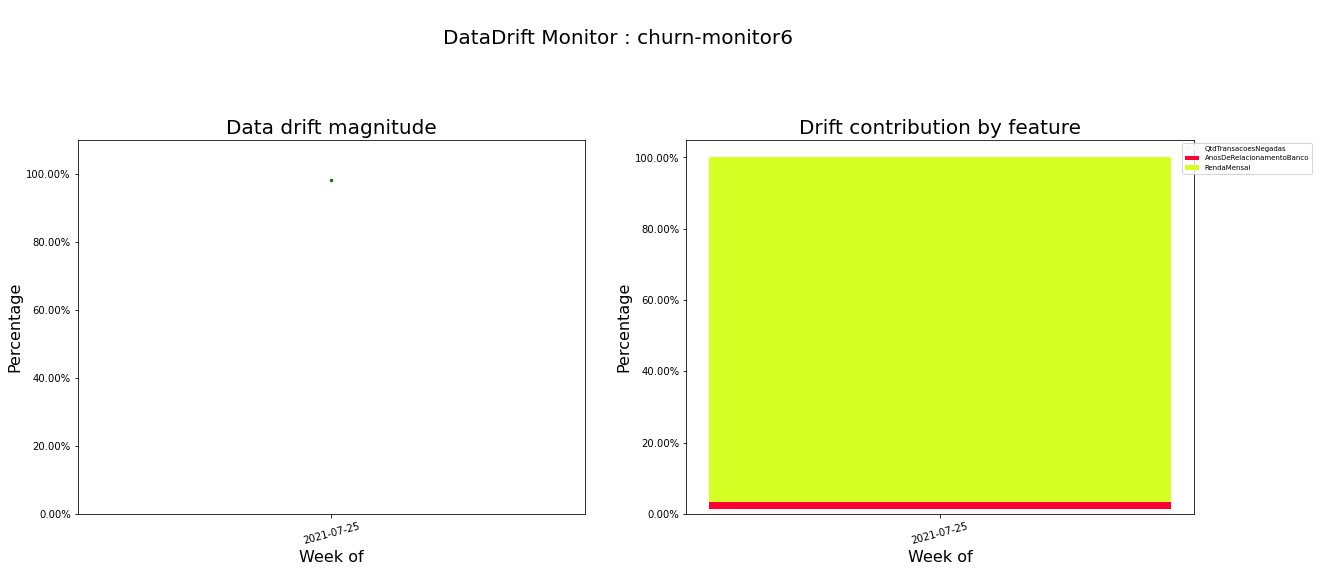

In [57]:
monitor.show(backfill_start_date, backfill_end_date)

## Enable the monitor's pipeline schedule

Turn on a scheduled pipeline which will anlayze the target dataset for drift every `frequency`. Use the latency parameter to adjust the start time of the pipeline. For instance, if it takes 24 hours for my data processing pipelines for data to arrive in the target dataset, set latency to 24.

In [0]:
# enable the pipeline schedule and recieve email alerts
monitor.enable_schedule()

# disable the pipeline schedule 
#monitor.disable_schedule()

## Delete compute target

Do not delete the compute target if you intend to keep using it for the data drift monitor scheduled runs or otherwise. If the minimum nodes are set to 0, it will scale down soon after jobs are completed, and scale up the next time the cluster is needed.

In [0]:
# optionally delete the compute target
#compute_target.delete()

## Delete the DataDriftDetector

Invoking the `delete()` method on the object deletes the the drift monitor permanently and cannot be undone. You will no longer be able to find it in the UI and the `list()` or `get()` methods. The object on which delete() was called will have its state set to deleted and name suffixed with deleted. The baseline and target datasets and model data that was collected, if any, are not deleted. The compute is not deleted. The DataDrift schedule pipeline is disabled and archived.

In [0]:
monitor.delete()

## Next steps

  * See [our documentation](https://aka.ms/datadrift) or [Python SDK reference]